Opportunity Age - Main Stats: count    29256.000000
mean       291.650123
std        385.199646
min          0.000000
25%         19.000000
50%         84.000000
75%        443.000000
max       1957.000000
Name: Age, dtype: float64
Opportunity Amount - Main Stats: count     29256.000000
mean       1561.727769
std        7058.446151
min       -3215.000000
25%           0.000000
50%           0.000000
75%        1785.000000
max      500000.000000
Name: Amount, dtype: float64
Opportunity Owner Role - Main Stats: count    29256.000000
mean         6.378145
std          3.595576
min          0.000000
25%          4.000000
50%          5.000000
75%          9.000000
max         13.000000
Name: Owner Role, dtype: float64
Opportunity value - over the mean: Type                       1.018000e+04
Lead Source                1.089030e+05
Amount Currency            2.397500e+04
Amount                     4.139881e+07
Programme Discount (%)     4.963387e+04
Primary Campaign Source    2.503000e+03
A

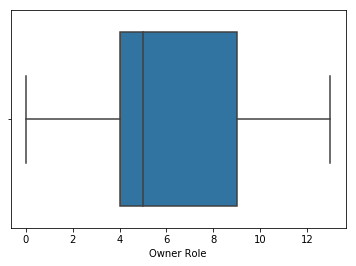

In [4]:
# Analysis of Real Estate Sales from 2001 to 2016
#
# Notebook focus: Finding factors driving differences in Actual Sales' Values vs. Assessed Sales' Value; 
# Using Random Forest and a Decision Tree from the SKLearn Library to derive numerical results. 
#
# Author: Jane Nikolova
# Occupation: Senior Consultant
# All Rights Reserved. 
# Date: May, 2019
#
# Data Source - Real Estate Sales 2001-2016
# https://catalog.data.gov/dataset/real-estate-sales-2001-2016

# Libraries - SKLearn, Pandas, NumPy, Matplotlib 


###### Decision tree test score ######
###### Random forest classifier - test score ######

import pandas
import xgboost
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import collections
from sklearn import tree
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import Normalizer, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from matplotlib import image
from sklearn.tree import export_graphviz
import pydotplus
import graphviz 


#Use data loading function to load & transform the data - 
import SalesforceDataFactory
dataFile = 'Real_Estate_Sales_2001-2016.csv'
XY = SalesforceDataFactory.allDataForOutcome(dataFile, 'SalesRatio')
X = XY[0]
Y = XY[1]

# DATA EXPLORATION: 
#
# Explore the data - plot distributions and outliers - transform & prune:
print('Opportunity Age - Main Stats:', X['Age'].describe())
#Opportunity Age - Main Stats: count    29256.000000
#mean       291.650123
#std        385.199646
#min          0.000000
#25%         19.000000
#50%         84.000000
#75%        443.000000
#max       1957.000000
print('Opportunity Amount - Main Stats:', X['Amount'].describe())
#Opportunity Amount - Main Stats: count     29256.000000
#mean       1561.727769
#std        7058.446151
#min       -3215.000000
#25%           0.000000
#50%           0.000000
#75%        1785.000000
#max      500000.000000

print('Opportunity Owner Role - Main Stats:', X['Owner Role'].describe())
#Opportunity Owner Role - Main Stats: count    29256.000000
#mean         6.378145
#std          3.595576
#min          0.000000
#25%          4.000000
#50%          5.000000
#75%          9.000000
#max         13.000000
import seaborn as sns
sns.boxplot(x=X['Owner Role'])
new_business_over_mean = X[(X['Amount']>1561.727)].sum()#mean      
new_business_over10k = X[(X['Amount']>10000)].sum()#~ 333
new_business_over20k = X[(X['Amount']>20000)].sum()#~ 92
print('Opportunity value - over the mean:',new_business_over_mean)
print('Opportunity value - over 10k:',new_business_over10k)
print('Opportunity value - over 20k:',new_business_over20k)

print('Opportunity Account Type - Main Stats:', X['Account Type'].describe())

# PRE-PROCESSING - OUTLIERS, CORRELATIONS:

# TODO: Amount - very long tail - maybe cut & run a scenario for looking only at the tail. 

# Explore correlations - average age of deals that close, average amount of deals that close or drop. etc.  

# ! Feature engineering - add month from the Begin/Close date - its 12 categorical variables but may add more weight.
# Number of contacts, Discount on the deal. 

#Without transform columns functionality - 
train_x, test_x, train_y, test_y = train_test_split(X,Y, test_size=0.3)
#print(train_x.head())

# BUILD & FINE TUNE CUSTOM MODELS:
#
#Simple DT - 
from sklearn.tree import DecisionTreeClassifier
clf = tree.DecisionTreeClassifier(max_depth=2)
clf = clf.fit(train_x, train_y)
test_score1 = clf.score(test_x, test_y)
print("###### Decision tree test score ######")
print(test_score1)

from sklearn.ensemble import RandomForestClassifier
RF_clf = RandomForestClassifier(n_estimators=100, max_depth=2, max_features = 'sqrt')
RF_clf.fit(train_x, train_y)
test_score2 = RF_clf.score(test_x, test_y)
print("###### Random forest classifier - test score ######")
print(test_score2)

### Explore features scoring for both trees - i.e. prune and re-build models to 
### compare improved accuracy.

# Visualize data
reference_column_names_independent_vars = ['Type', 'Lead Source', 
                   'Amount Currency', 
                   'Amount', 
                   'Next Step',
                   'Fiscal Period', 
                   'Age', 
                   'Opportunity Owner', 
                   'Owner Role',
                   'Account Name',
                   'Programme Discount (%)',
                   'Primary Campaign Source',
                   'Account Type']


data_feature_names = reference_column_names_independent_vars
print(data_feature_names)
dot_data = tree.export_graphviz(clf,
                                feature_names=data_feature_names,
                                out_file=None,
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
colors = ('green', 'orange')
edges = collections.defaultdict(list)

for edge in graph.get_edge_list():
    edges[edge.get_source()].append(int(edge.get_destination()))

for edge in edges:
    edges[edge].sort()    
    for i in range(1):
        dest = graph.get_node(str(edges[edge][i]))[0]
        dest.set_fillcolor(colors[i])

graph.write_png('decision-tree-sf-data.png')

#Different method - 
# Show graph
Image(graph.create_png())
graph.write_pdf("decision-tree-sf-data.pdf")

#MOST IMPORTANT IDNEPENDENT VARIBBLES - Decision tree - but no elaborate pre-processing of the
# input varaibles - 
#
# - * 
# 

#Feature importances - DT:
print(dict(zip(X.columns, clf.feature_importances_)))
print("###### Decision tree features scores -  - * UPDATE FOR DISCOUNT ######")
#{'# - * UPDATE FOR DISCOUNT }

print("###### Random forest features scores -  much more subtle scoring ######")
#MOST IMPORTANT IDNEPENDENT VARIBBLES - Random forest - but no elaborate pre-processing of the
# input varaibles - 
#
# - * 
# 
print("###### - * UPDATE FOR DISCOUNT  ######,  etc")
print(dict(zip(X.columns, RF_clf.feature_importances_)))
#{'# - * UPDATE FOR DISCOUNT }
    
# ESTIMATING MDOELS' PERFORMANCE: 
# TODO: ROC Curves measurements - 
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

# load libraries
from sklearn.datasets import make_classification
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("###### AUC / ROC Estimators ######")

# Get predicted probabilities
y_score1 = clf.predict_proba(test_x)[:,1]
y_score2 = RF_clf.predict_proba(test_x)[:,1]

print(y_score1)

#Plot multi-class ROC:

#fpr = np.array()
#tpr = dict()
#y_score = clf.fit(train_x, train_y).predict_proba(test_x)
#n_classes = label_encoded_y_transformed.shape[0]
#print("test: ", test_y[0], y_score[0])
#roc_auc = dict()
#for i in range(n_classes):
    #print(i, test_y[i], y_score[:, i])
    #fpr[i], tpr[i], _ = roc_curve(test_y[i], y_score[:, i])
    #roc_auc[i] = auc(fpr[i], tpr[i])
#colors = cycle(['blue', 'red', 'green'])
#for i, color in zip(range(n_classes), colors):
    #plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             #label='ROC curve of class {0} (area = {1:0.2f})'
             #''.format(i, roc_auc[i]))

#plt.plot([0, 1], [0, 1], 'k--', lw=lw)
#plt.xlim([-0.05, 1.0])
#plt.ylim([0.0, 1.05])
#plt.xlabel('False Positive Rate')
#plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic for multi-class Y variable - Stage')
#plt.legend(loc="lower right")
#plt.show()

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates

#false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_y, y_score1)
#false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(test_y, y_score2)
#print('roc_auc_score for DecisionTree: ', roc_auc_score(test_y, y_score1)) 
#print('roc_auc_score for Random Forest: ', roc_auc_score(test_y, y_score2))

# Plot ROC curves
#plt.subplots(1, figsize=(10,10))    
#plt.title('Receiver Operating Characteristic - DecisionTree')
#plt.plot(false_positive_rate1, true_positive_rate1)
#plt.plot([0, 1], ls="--")
#plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
#plt.ylabel('True Positive Rate')
#plt.xlabel('False Positive Rate')
#plt.show()
    
# TODO: XBooster , ExtraTrees & compare again using ROC curves - 

import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

#import matplotlib.image as mpimg
#plt.show()
#plt.imshow(img)

# CPU suffers with this one - 
# Build a forest and compute the feature importances
#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)

#forest.fit(X, label_encoded_y_transformed)
#print("###### Random forest classifier - Extra trees score ######")
#test_score3 = forest.score(test_x, test_y)
#print(test_score3)

print("###### Next: Run the models on new data in 1-2 weeks ######")
print("###### Next: Are trends consistent? ######")
print("###### Next: Are the models predictive? ######")


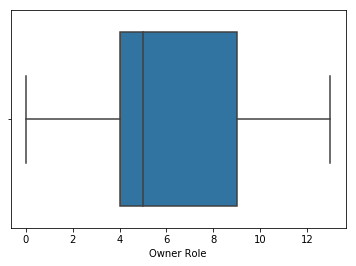

In [37]:

import seaborn as sns
sns.boxplot(x=X['Owner Role'])



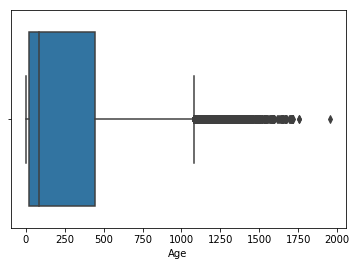

In [38]:
import seaborn as sns
sns.boxplot(x=X['Age'])